# Detecting malaria in blood smear images

### The Problem
Malaria is a mosquito-borne disease caused by the parasite _Plasmodium_. There are an estimated 219 million cases of malaria annually, with 435,000 deaths, many of whom are children. Malaria is prevalent in sub-tropical regions of Africa.

Microscopy is the most common and reliable method for diagnosing malaria and computing parasitic load. 

With this technique, malaria parasites are identified by examining a drop of the patient’s blood, spread out as a “blood smear” on a slide. Prior to examination, the specimen is stained (most often with the Giemsa stain) to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria.

![Malaria-positive blood smear](https://www.cdc.gov/malaria/images/microscopy/parasites_arrows.jpg)

Blood smear from a patient with malaria; microscopic examination shows _Plasmodium falciparum_ parasites (arrows) infecting some of the patient’s red blood cells. (CDC photo)

However, the diagnostic accuracy of this technique is dependent on human expertise and can be affectived by and observer's variability.

### Deep learning as a diagnostic aid
Recent advances in computing and deep learning techniques have led to the applications of large-scale medical image analysis. Here, we aim to use a convolutional neural network (CNN) in order to quickly and accurately classify parasitized from healthy cells from blood smears.


### About the dataset
A [dataset](https://ceb.nlm.nih.gov/repositories/malaria-datasets/) of parasitized and unparasitized cells from blood smear slides was collected and annotated by [Rajaraman et al](https://doi.org/10.7717/peerj.4568). The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from Giemsa-stained thin blood smear slides from 150 P. falciparum-infected and 50 healthy patients collected and photographed at Chittagong Medical College Hospital, Bangladesh. There are also CSV files containing the Patient-ID to cell mappings for the parasitized and uninfected classes. The CSV file for the parasitized class contains 151 patient-ID entries. The slide images for the parasitized patient-ID “C47P8thinOriginal” are read from two different microscope models (Olympus and Motif). The CSV file for the uninfected class contains 201 entries since the normal cells from the infected patients’ slides also make it to the normal cell category (151+50 = 201).

The data appears along with the publication:
Rajaraman S, Antani SK, Poostchi M, Silamut K, Hossain MA, Maude, RJ, Jaeger S, Thoma GR. (2018) Pre-trained convolutional neural networks as feature extractors toward improved Malaria parasite detection in thin blood smear images. PeerJ6:e4568 https://doi.org/10.7717/peerj.4568

In [10]:
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
from keras.datasets import mnist

## Simple Keras example with MNIST

In [8]:
#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [9]:
# Data preprocessing
#reshape data to fit model
X_train = X_train.reshape(60000,28,28,1) #28 x 28 image size, greyscale
X_test = X_test.reshape(10000,28,28,1)

In [11]:

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0] # shape (60000, 10) 10 categories

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [21]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax')) # 10 outputs

In [22]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 204s 3ms/step - loss: 0.4482 - acc: 0.9378 - val_loss: 0.0812 - val_acc: 0.9747
Epoch 2/3
60000/60000 [==============================] - 222s 4ms/step - loss: 0.0666 - acc: 0.9794 - val_loss: 0.0848 - val_acc: 0.9736
Epoch 3/3
60000/60000 [==============================] - 247s 4ms/step - loss: 0.0492 - acc: 0.9846 - val_loss: 0.0930 - val_acc: 0.9748


In [25]:
# Predictions
model.predict(X_test[:4])

array([[1.0937500e-11, 2.0935111e-12, 1.2259348e-08, 8.1907513e-07,
        3.2641694e-15, 2.8968859e-14, 7.2036843e-16, 9.9999905e-01,
        4.9250564e-09, 8.9496879e-08],
       [1.7223412e-08, 1.2890739e-06, 9.9978155e-01, 4.8170758e-08,
        2.7063560e-10, 3.9016520e-14, 2.1715867e-04, 3.9005865e-11,
        1.8586826e-08, 5.5360210e-15],
       [4.4435382e-07, 9.9884427e-01, 9.0430285e-06, 7.0622292e-08,
        7.7383098e-05, 6.8348040e-06, 1.8682509e-05, 3.4501702e-06,
        1.0398269e-03, 2.4480352e-08],
       [9.9999988e-01, 2.2280416e-14, 2.1360684e-10, 1.5837303e-12,
        2.4452207e-13, 6.8840086e-11, 7.4949568e-08, 6.5273603e-16,
        1.1704834e-12, 4.2571802e-10]], dtype=float32)

In [26]:
# Actual
y_test[:4]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Malaria Dataset
Medium post:
https://towardsdatascience.com/detecting-malaria-using-deep-learning-fd4fdcee1f5a

Data:
https://ceb.nlm.nih.gov/repositories/malaria-datasets/

### Preprocess dataset

In [32]:
os.listdir('../data/cell_images/')

['Parasitized', 'Uninfected']

In [61]:
import random
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Get file paths for files
base_dir = os.path.join('../data/cell_images')
infected_dir = os.path.join(base_dir, 'Parasitized')
healthy_dir = os.path.join(base_dir, 'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')

len(infected_files), len(healthy_files)

(13779, 13779)

In [62]:
np.random.seed(1)

# Build a dataframe of filenames with labels

files = pd.DataFrame(data={'filename': infected_files, 'label': ['malaria' for i in range(len(infected_files))]})
files = pd.concat([files, pd.DataFrame(data={'filename': healthy_files, 'label': ['healthy' for i in range(len(healthy_files))]})])
files = files.sample(frac=1).reset_index(drop=True) # Shuffle rows
files.head()

,filename,label
0,../data/cell_images/Parasitized/C136P97ThinF_I...,malaria
1,../data/cell_images/Parasitized/C167P128ReThin...,malaria
2,../data/cell_images/Parasitized/C111P72ThinF_I...,malaria
3,../data/cell_images/Uninfected/C116P77ThinF_IM...,healthy
4,../data/cell_images/Parasitized/C60P21thinF_IM...,malaria


### Split data into train, test, split sets

We split the data into a 60/30/10 train/test/validation set

In [79]:
X_train, X_test, y_train, y_test = train_test_split(files.filename.values, files.label.values, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, , test_size=0.1, random_state=42)


In [81]:
X_train_files.shape, X_val_files.shape, y_train_files.shape, y_val_files.shape

((15624,), (1737,), (15624,), (1737,))

In [97]:
# Read and resize images 
nrows = 125
ncols = 125
channels = 3

cv2.imread(X_train_files[0], cv2.IMREAD_COLOR)
cv2.resize(cv2.imread(X_train_files[0], cv2.IMREAD_COLOR), (nrows, ncols), interpolation=cv2.INTER_CUBIC).shape

(125, 125, 3)

In [102]:
# Resize images
import cv2
import threading
from concurrent import futures


IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
X_train_inp = [(idx, img, len(X_train)) for idx, img in enumerate(X_train)]
X_val_inp = [(idx, img, len(X_val)) for idx, img in enumerate(X_val)]
X_test_inp = [(idx, img, len(X_test)) for idx, img in enumerate(X_test)]

print('Loading Train Images:')
X_train_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in X_train_inp],
                        [record[1] for record in X_train_inp],
                        [record[2] for record in X_train_inp])
X_train = np.array(list(X_train_map))

print('\nLoading Validation Images:')
X_val_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in X_val_inp],
                        [record[1] for record in X_val_inp],
                        [record[2] for record in X_val_inp])
X_val = np.array(list(X_val_map))

print('\nLoading Test Images:')
X_test_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in X_test_inp],
                        [record[1] for record in X_test_inp],
                        [record[2] for record in X_test_inp])
X_test = np.array(list(X_test_map))

X_train.shape, X_val.shape, X_test.shape

Loading Train Images:
ThreadPoolExecutor-7_0: working on img num: 0
ThreadPoolExecutor-7_18: working on img num: 5000
ThreadPoolExecutor-7_17: working on img num: 10000
ThreadPoolExecutor-7_15: working on img num: 15000
ThreadPoolExecutor-7_14: working on img num: 17360


TypeError: bad argument type for built-in operation

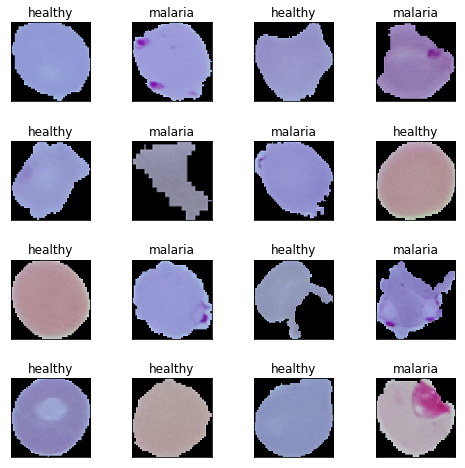

In [85]:
import matplotlib.pyplot as plt%matplotlib inline


plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , X_train.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(X_train[r[0]]/255.)
    plt.title('{}'.format(y_train[r[0]]))
    plt.xticks([]) , plt.yticks([])

### Encode text category labels

In [64]:
from sklearn.preprocessing import LabelEncoder

In [99]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

X_train_imgs_scaled = X_train / 255.
X_val_imgs_scaled = X_val / 255.

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)

print(y_train[:6], y_train_enc[:6])

['malaria' 'healthy' 'malaria' 'healthy' 'healthy' 'healthy'] [1 0 1 0 0 0]


In [73]:
# Use model from MNIST example

model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [74]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 123, 123, 64)      1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 121, 121, 32)      18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 468512)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 937026    
Total params: 957,282
Trainable params: 957,282
Non-trainable params: 0
_________________________________________________________________


In [103]:
history = model.fit(x=X_train_imgs_scaled, y=y_train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(X_val_imgs_scaled, y_val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

NameError: name 'y_train_labels_enc' is not defined

In [6]:
# Build a simple CNN
input_shape = (5,5)

model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

ValueError: Input 0 is incompatible with layer conv2d_1: expected ndim=4, found ndim=3